In [1]:
# Preparing the Data

In [2]:
from __future__ import unicode_literals, print_function, division

In [3]:
import glob

def findFiles(path): 
    return glob.glob(path)

findFiles('data/names/*.txt')

['data/names\\Arabic.txt',
 'data/names\\Chinese.txt',
 'data/names\\Czech.txt',
 'data/names\\Dutch.txt',
 'data/names\\English.txt',
 'data/names\\French.txt',
 'data/names\\German.txt',
 'data/names\\Greek.txt',
 'data/names\\Irish.txt',
 'data/names\\Italian.txt',
 'data/names\\Japanese.txt',
 'data/names\\Korean.txt',
 'data/names\\Polish.txt',
 'data/names\\Portuguese.txt',
 'data/names\\Russian.txt',
 'data/names\\Scottish.txt',
 'data/names\\Spanish.txt',
 'data/names\\Vietnamese.txt']

In [4]:
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [5]:
import unicodedata

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!='Mn'
        and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [6]:
from io import open

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [7]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [8]:
import os

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(all_categories)
print(n_categories)
print(category_lines['Italian'][:5])

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [9]:
# Turning Names into Tensors

In [10]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> Tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
# Creating the Network

In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [14]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8506, -2.8894, -2.8991, -2.8261, -2.8358, -2.9984, -2.9043, -2.8229,
         -2.8523, -2.9895, -2.9626, -2.9822, -2.8707, -2.8493, -2.9884, -2.8779,
         -2.7984, -2.8639]], grad_fn=<LogSoftmaxBackward>)


In [15]:
# Training

In [16]:
# Preparing for Training

In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 16)


In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Asfour
category = Italian / line = Masi
category = Italian / line = Cingolani
category = Korean / line = Sin
category = Italian / line = Lama
category = Italian / line = De palma
category = Korean / line = Chu
category = Chinese / line = Chin
category = Russian / line = Tsaregorodtsev
category = Greek / line = Pantelakos


In [19]:
# Training the Network

In [20]:
criterion = nn.NLLLoss()

In [21]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [22]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name, guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 29s) 2.8259 Kanaan / Irish ✗ (Arabic)
10000 10% (0m 57s) 1.8149 Roijakkers / Dutch ✓
15000 15% (1m 25s) 0.6161 Shon / Korean ✓
20000 20% (1m 52s) 2.5593 O'Rourke / Polish ✗ (Irish)
25000 25% (2m 19s) 2.0932 Yount / French ✓
30000 30% (2m 47s) 1.3057 Hong / Chinese ✓
35000 35% (3m 15s) 0.0286 Garofalis / Greek ✓
40000 40% (3m 45s) 0.0378 Malinowski / Polish ✓
45000 45% (4m 15s) 1.1108 Babineaux / French ✓
50000 50% (4m 44s) 0.0878 Takaki / Japanese ✓
55000 55% (5m 14s) 1.2456 Kouri / Arabic ✓
60000 60% (5m 45s) 1.2584 Ho / Korean ✗ (Vietnamese)
65000 65% (6m 17s) 0.1364 Kagawa / Japanese ✓
70000 70% (6m 48s) 2.8392 Braden / Dutch ✗ (Irish)
75000 75% (7m 19s) 2.6943 Shirai / Arabic ✗ (Japanese)
80000 80% (7m 49s) 2.0210 Wiater / German ✗ (Polish)
85000 85% (8m 19s) 1.3710 Sobol / Polish ✓
90000 90% (8m 50s) 0.3535 Miodushevsky / Russian ✓
95000 95% (9m 20s) 0.3062 Sorrentino / Italian ✓
100000 100% (9m 50s) 1.6640 Schuyler / German ✗ (Dutch)


In [23]:
# Plotting the Results

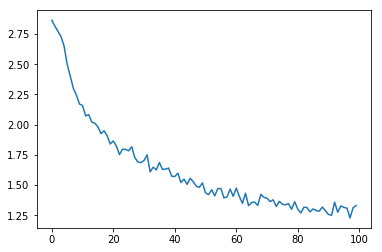

In [25]:
import matplotlib.pyplot as plt

plt.figure
plt.plot(all_losses)

In [26]:
# Evaluating the results

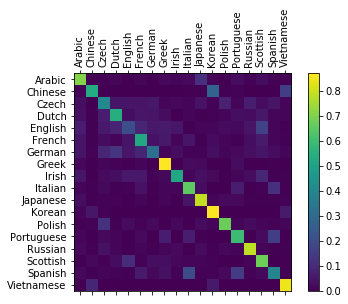

In [27]:
import matplotlib.ticker as ticker

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [28]:
# Running on User Input

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # Get N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.64) Russian
(-1.06) Czech
(-3.22) Polish

> Jackson
(-0.24) Scottish
(-2.40) Russian
(-2.87) English

> Satoshi
(-0.88) Japanese
(-1.55) Italian
(-2.11) Polish
